In [1]:
import random
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import Levenshtein
import networkx as nx

from collections import defaultdict
from itertools import product, combinations

In [2]:
DATASET_DIRECTORY = '../datasets/new'

In [3]:
def report_pairing(df):
    print('Number of paired sequences: {:15}'.format(len(df)))
    print('Number of unique heavy:     {:15}'.format(df['heavy_id'].nunique()))
    print('Number of unique light:     {:15}'.format(df['light_id'].nunique()))
    print('Number of unique pairs:     {:15} ({:.2f}%)'.format(df['pair_id'].nunique(),
                                                            df['pair_id'].nunique() / len(df) * 100))
def report_germlines(df):
    print('Number of heavy germlines:  {:15}'.format(df['heavy_germline'].nunique()))
    print('Number of light germlines:  {:15}'.format(df['light_germline'].nunique()))
    print('Number of germlines pair:   {:15}'.format(len(df[['heavy_germline', 'light_germline']].drop_duplicates())))
    print('Number of V heavy germlines:{:15}'.format(len(df['heavy_germline'].map(lambda x: x.split('-')[0]).drop_duplicates())))
    print('Number of D heavy germlines:{:15}'.format(len(df['heavy_germline'].map(lambda x: x.split('-')[1]).drop_duplicates())))
    print('Number of J heavy germlines:{:15}'.format(len(df['heavy_germline'].map(lambda x: x.split('-')[2]).drop_duplicates())))
    print('Number of V light germlines:{:15}'.format(len(df['light_germline'].map(lambda x: x.split('-')[0]).drop_duplicates())))
    print('Number of J light germlines:{:15}'.format(len(df['light_germline'].map(lambda x: x.split('-')[1]).drop_duplicates())))

def show_germline_counter(heavy_germlines, light_germlines, ax_heavy, ax_light):
    ax_heavy.bar(range(len(heavy_germlines)), heavy_germlines.map(np.log10))
    ax_light.bar(range(len(light_germlines)), light_germlines.map(np.log10))

def show_coocc_matrix(coocc_matrix, heavy_germlines, light_germlines, ax):
    ret = ax.imshow(np.log10(coocc_matrix + 1))
    ax.set_xticks([])
    ax.set_yticks([])
    return ret

### All sequences 

In [4]:
all_sequences = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'sequences/sequences.csv'), index_col=0)
report_pairing(all_sequences)
print()
report_germlines(all_sequences)

Number of paired sequences:         1622802
Number of unique heavy:             1604717
Number of unique light:              699889
Number of unique pairs:             1622674 (99.99%)

Number of heavy germlines:              294
Number of light germlines:               76
Number of germlines pair:             12416
Number of V heavy germlines:              7
Number of D heavy germlines:              7
Number of J heavy germlines:              6
Number of V light germlines:             18
Number of J light germlines:             12


### Clusters 

In [5]:
clusters = pd.read_csv('{}/clustering/sequences.tsv'.format(DATASET_DIRECTORY), sep='\t', header=None).rename({
    0: 'representative',
    1: 'sequences'
    
}, axis=1)

In [6]:
sizes = []
for _, data in clusters.groupby('representative'):
    sizes.append(len(data))

In [7]:
print('Number of clusters: {}'.format(clusters['representative'].nunique()))
print('Mean size:   {:.3f}\nMedian size: {:.0f}'.format(np.mean(sizes), np.median(sizes)))
sizes_dict = defaultdict(int)
for s in sizes:
    sizes_dict[s] += 1
sizes_df = defaultdict(list)
for key, item in sizes_dict.items():
    sizes_df['size'].append(key)
    sizes_df['number'].append(item)
sizes_df = pd.DataFrame(sizes_df)
sizes_df = sizes_df.sort_values(by='size')
print('Number of singleton: {}'.format(sizes_df.iloc[0, 1]))
print('Lergest cluster: {}'.format(sizes_df.iloc[-1, 0]))

Number of clusters: 1357063
Mean size:   1.196
Median size: 1
Number of singleton: 1290392
Lergest cluster: 3940


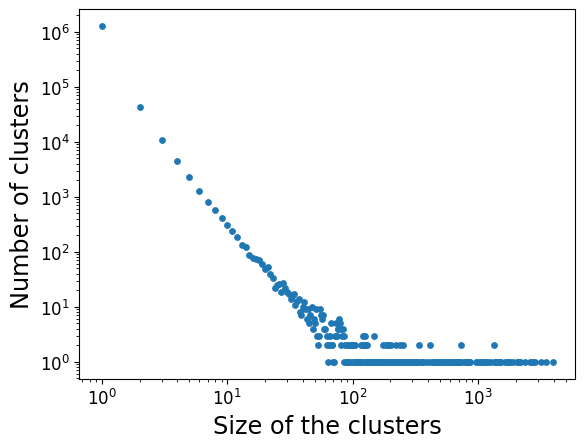

In [8]:
fig, ax = plt.subplots(1)

ax.scatter(sizes_df['size'], sizes_df['number'], s=15)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel('Number of clusters', fontsize='xx-large')
ax.set_xlabel('Size of the clusters', fontsize='xx-large')

ax.tick_params(axis='both', which='major', labelsize=12)

fig.savefig('pictures/cluster-scatterplot.png', bbox_inches='tight')

### Clusters only representative

In [9]:
representative_sequences = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'sequences/representative.csv'), index_col=0)
report_pairing(representative_sequences)
print()
report_germlines(representative_sequences)

Number of paired sequences:         1357155
Number of unique heavy:             1348625
Number of unique light:              595539
Number of unique pairs:             1357063 (99.99%)

Number of heavy germlines:              294
Number of light germlines:               76
Number of germlines pair:             11976
Number of V heavy germlines:              7
Number of D heavy germlines:              7
Number of J heavy germlines:              6
Number of V light germlines:             18
Number of J light germlines:             12


### Germline based splitting

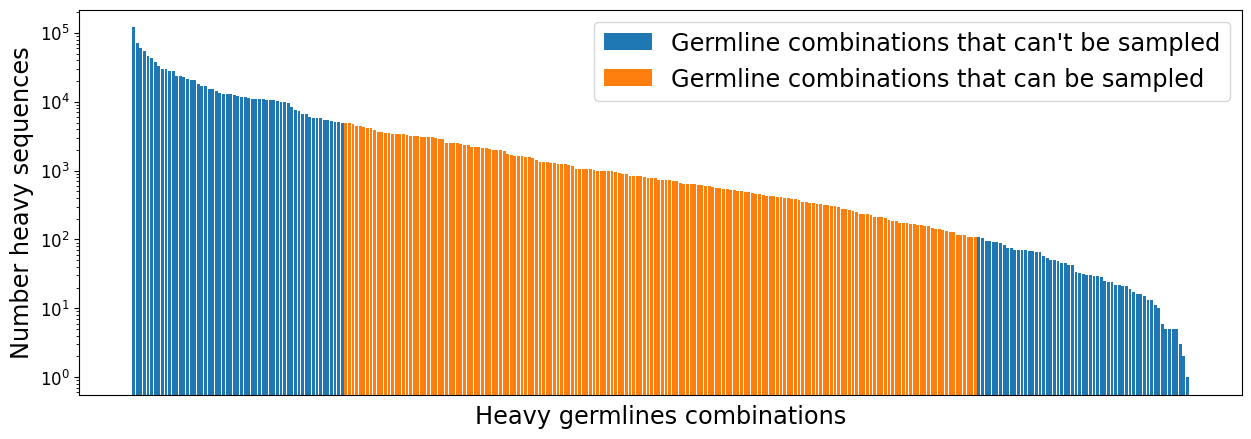

In [10]:
counter = representative_sequences.groupby('heavy_germline').count()['heavy_id'].sort_values(ascending=False)
selected = counter[(counter > counter.quantile(0.20)) & (counter < counter.quantile(0.80))]

fig, ax = plt.subplots(1)

ax.bar(range(len(counter)), counter)

a = counter.index.get_loc(selected.index[0])
b = counter.index.get_loc(selected.index[-1])
ax.bar(range(a, b + 1), selected)

ax.set_yscale('log')

ax.legend(['Germline combinations that can\'t be sampled', 'Germline combinations that can be sampled'],
          fontsize="xx-large")

ax.set_xticks([])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel('Number heavy sequences', fontsize='xx-large')
ax.set_xlabel('Heavy germlines combinations', fontsize='xx-large')

fig.set_size_inches(15, 5)
fig.savefig('pictures/heavy-germlines-combinations-count.png', bbox_inches='tight')

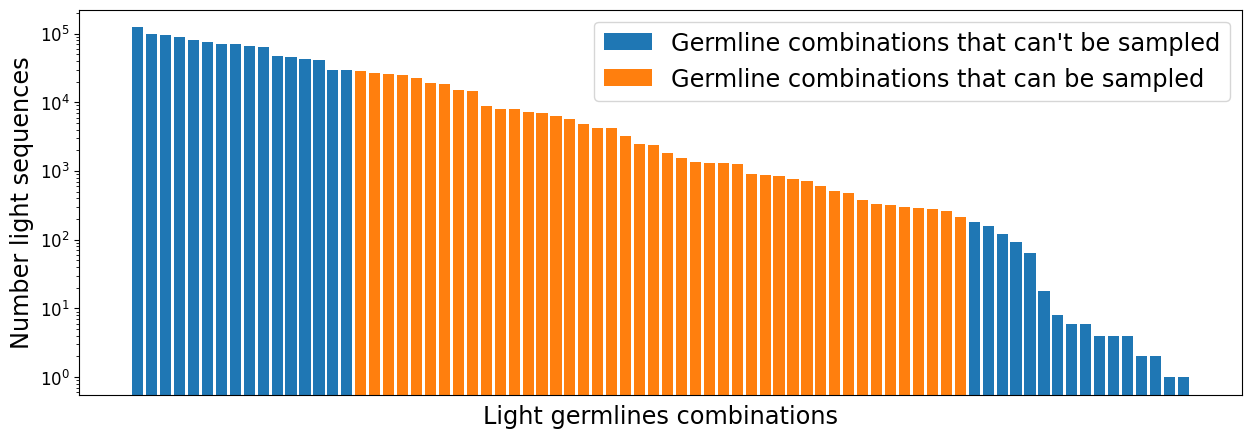

In [11]:
counter = representative_sequences.groupby('light_germline').count()['light_id'].sort_values(ascending=False)
selected = counter[(counter > counter.quantile(0.20)) & (counter < counter.quantile(0.80))]

fig, ax = plt.subplots(1)

ax.bar(range(len(counter)), counter)

a = counter.index.get_loc(selected.index[0])
b = counter.index.get_loc(selected.index[-1])
ax.bar(range(a, b + 1), selected)

ax.set_yscale('log')

ax.legend(['Germline combinations that can\'t be sampled', 'Germline combinations that can be sampled'],
          fontsize='xx-large')

ax.set_xticks([])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel('Number light sequences', fontsize='xx-large')
ax.set_xlabel('Light germlines combinations', fontsize='xx-large')

fig.set_size_inches(15, 5)
fig.savefig('pictures/light-germlines-combinations-count.png', bbox_inches='tight')

### Train sequences

In [12]:
train_sequences = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'sequences/train.csv'), index_col=0)
report_pairing(train_sequences)
print()
report_germlines(train_sequences)

Number of paired sequences:          716325
Number of unique heavy:              713129
Number of unique light:              325309
Number of unique pairs:              716295 (100.00%)

Number of heavy germlines:              261
Number of light germlines:               68
Number of germlines pair:              8628
Number of V heavy germlines:              7
Number of D heavy germlines:              7
Number of J heavy germlines:              6
Number of V light germlines:             18
Number of J light germlines:             12


### Val sequences

In [18]:
val_sequences = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'sequences/val.csv'), index_col=0)
report_pairing(val_sequences)
print()
report_germlines(val_sequences)

Number of paired sequences:          271233
Number of unique heavy:              270406
Number of unique light:              134013
Number of unique pairs:              271230 (100.00%)

Number of heavy germlines:              270
Number of light germlines:               68
Number of germlines pair:              8125
Number of V heavy germlines:              7
Number of D heavy germlines:              7
Number of J heavy germlines:              6
Number of V light germlines:             17
Number of J light germlines:             11


### Test sequences

In [19]:
test_sequences = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'sequences/test.csv'), index_col=0)
report_pairing(test_sequences)
print()
report_germlines(test_sequences)

Number of paired sequences:          369597
Number of unique heavy:              368303
Number of unique light:              176290
Number of unique pairs:              369586 (100.00%)

Number of heavy germlines:              291
Number of light germlines:               73
Number of germlines pair:              9575
Number of V heavy germlines:              7
Number of D heavy germlines:              7
Number of J heavy germlines:              6
Number of V light germlines:             17
Number of J light germlines:             11


### Random pairing

In [15]:
WHICH = 'train'

random_pairs = pd.read_csv('{}/classificator/random/{}_random/{}_random.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
report_pairing(random_pairs)

random_pairs_total = pd.read_csv('{}/classificator/random/{}_random/{}.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
print(len(random_pairs_total), 
      len(random_pairs_total[random_pairs_total['class'] == 0]),
      len(random_pairs_total[random_pairs_total['class'] == 1]))

Number of paired sequences:          716325
Number of unique heavy:              451185
Number of unique light:              212387
Number of unique pairs:              716097 (99.97%)
1432650 716325 716325


In [21]:
WHICH = 'val'

random_pairs = pd.read_csv('{}/classificator/random/{}_random/{}_random.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
report_pairing(random_pairs)

random_pairs_total = pd.read_csv('{}/classificator/random/{}_random/{}.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
print(len(random_pairs_total), 
      len(random_pairs_total[random_pairs_total['class'] == 0]),
      len(random_pairs_total[random_pairs_total['class'] == 1]))

Number of paired sequences:          271233
Number of unique heavy:              171061
Number of unique light:               87773
Number of unique pairs:              271142 (99.97%)
542466 271233 271233


In [22]:
WHICH = 'test'

random_pairs = pd.read_csv('{}/classificator/random/{}_random/{}_random.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
report_pairing(random_pairs)

random_pairs_total = pd.read_csv('{}/classificator/random/{}_random/{}.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
print(len(random_pairs_total), 
      len(random_pairs_total[random_pairs_total['class'] == 0]),
      len(random_pairs_total[random_pairs_total['class'] == 1]))

Number of paired sequences:          369597
Number of unique heavy:              232860
Number of unique light:              115172
Number of unique pairs:              369481 (99.97%)
739194 369597 369597


### Germline pairing - ALL

In [13]:
germline_file_all = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'classificator/germline_all/train/train_germ.csv'), index_col=0)
heavy_germlines = germline_file_all.groupby('heavy_germline')['counter'].sum().sort_values(ascending=False)
light_germlines = germline_file_all.groupby('light_germline')['counter'].sum().sort_values(ascending=False)

coocc_matrix_train = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        coocc_matrix_train[r][c] = germline_file_all[(germline_file_all['heavy_germline'] == h) & 
                                                     (germline_file_all['light_germline'] == l)]['counter'].iloc[0]

In [24]:
train_neg = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 
                                       'classificator/germline_all/train/train-germline_pairing-alpha_1000.csv'), index_col=0)
germlines_train = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 
                                             'classificator/germline_all/train/train_germ.csv'), index_col=0)

train_neg = pd.merge(train_neg, germlines_train, how='left')

zero_pairs = defaultdict(list)

for h, data1 in train_neg.groupby('heavy_germline'):
    for l, data2 in data1.groupby('light_germline'):
        zero_pairs['heavy_germline'].append(h)
        zero_pairs['light_germline'].append(l)
        zero_pairs['count'].append(len(data2))

zero_pairs = pd.DataFrame(zero_pairs)

coocc_matrix_train_zero = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        x = zero_pairs[(zero_pairs['heavy_germline'] == h) &
                       (zero_pairs['light_germline'] == l)]['count']
        if len(x) != 0:
            coocc_matrix_train_zero[r][c] = x.iloc[0]

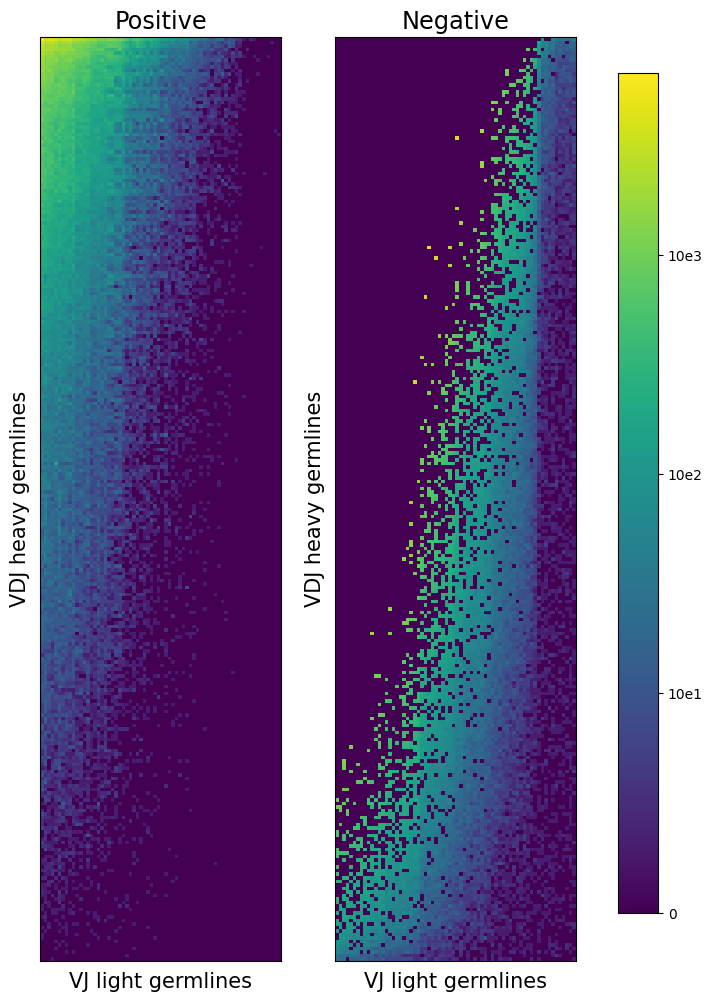

In [28]:
vmin = 0
vmax = max(np.max(coocc_matrix_train_zero), np.max(coocc_matrix_train))

fig, axs = plt.subplots(1, 2)
axs = axs.flatten()

fig.set_size_inches(8, 12)

ret1 = axs[0].imshow(np.log10(coocc_matrix_train + 1), vmin=0, vmax=np.log10(vmax))
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('Positive', fontsize='xx-large')

axs[0].set_ylabel('VDJ heavy germlines', fontsize=15)
axs[0].set_xlabel('VJ light germlines', fontsize=15)

axs[1].imshow(np.log10(coocc_matrix_train_zero + 1), vmin=0, vmax=np.log10(vmax))
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Negative', fontsize='xx-large')

axs[1].set_ylabel('VDJ heavy germlines', fontsize=15)
axs[1].set_xlabel('VJ light germlines', fontsize=15)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ret1, cbar_ax, axs)

cbar_ax.set_yticks([0, 1, 2, 3])
cbar_ax.set_yticklabels(['0', '10e1', '10e2', '10e3'])

fig.savefig('pictures/co-occ-matrix-train-germ-all.png', bbox_inches='tight')

In [15]:
WHICH = 'train'

random_pairs = pd.read_csv('{}/classificator/germline_all/{}/{}-germline_pairing-alpha_1000.csv'.format(DATASET_DIRECTORY, 
                                                                                                        WHICH, WHICH), index_col=0)
report_pairing(random_pairs)

random_pairs_total = pd.read_csv('{}/classificator/germline_all/{}/{}.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
print(len(random_pairs_total), 
      len(random_pairs_total[random_pairs_total['class'] == 0]),
      len(random_pairs_total[random_pairs_total['class'] == 1]))

Number of paired sequences:          716325
Number of unique heavy:              172284
Number of unique light:              102598
Number of unique pairs:              702818 (98.11%)
1432650 716325 716325


In [16]:
WHICH = 'val'

random_pairs = pd.read_csv('{}/classificator/germline_all/{}/{}-germline_pairing-alpha_1000.csv'.format(DATASET_DIRECTORY, 
                                                                                                        WHICH, WHICH), index_col=0)
report_pairing(random_pairs)

random_pairs_total = pd.read_csv('{}/classificator/germline_all/{}/{}.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
print(len(random_pairs_total), 
      len(random_pairs_total[random_pairs_total['class'] == 0]),
      len(random_pairs_total[random_pairs_total['class'] == 1]))

Number of paired sequences:          271233
Number of unique heavy:               79278
Number of unique light:               50571
Number of unique pairs:              268702 (99.07%)
542466 271233 271233


In [17]:
WHICH = 'test'

random_pairs = pd.read_csv('{}/classificator/germline_all/{}/{}-germline_pairing-alpha_1000.csv'.format(DATASET_DIRECTORY, 
                                                                                                        WHICH, WHICH), index_col=0)
report_pairing(random_pairs)

random_pairs_total = pd.read_csv('{}/classificator/germline_all/{}/{}.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
print(len(random_pairs_total), 
      len(random_pairs_total[random_pairs_total['class'] == 0]),
      len(random_pairs_total[random_pairs_total['class'] == 1]))

Number of paired sequences:          369597
Number of unique heavy:              109264
Number of unique light:               62194
Number of unique pairs:              366160 (99.07%)
739194 369597 369597


### Germline pairing - only v

In [30]:
germline_file_only_v = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'classificator/germline_v/train_only_v/train_germ_only_v.csv'), index_col=0)
heavy_germlines = germline_file_only_v.groupby('heavy_germline')['counter'].sum().sort_values(ascending=False)
light_germlines = germline_file_only_v.groupby('light_germline')['counter'].sum().sort_values(ascending=False)

coocc_matrix_train = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        coocc_matrix_train[r][c] = germline_file_only_v[(germline_file_only_v['heavy_germline'] == h) & 
                                                     (germline_file_only_v['light_germline'] == l)]['counter'].iloc[0]

In [31]:
train_neg = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 
                                       'classificator/germline_v/train_only_v/train-germline_pairing-alpha_1000_only_v.csv'), index_col=0)
germlines_train = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 
                                             'classificator/germline_v/train_only_v/train_germ_only_v.csv'), index_col=0)

train_neg = pd.merge(train_neg, germlines_train, how='left')

zero_pairs = defaultdict(list)

for h, data1 in train_neg.groupby('heavy_germline'):
    for l, data2 in data1.groupby('light_germline'):
        zero_pairs['heavy_germline'].append(h)
        zero_pairs['light_germline'].append(l)
        zero_pairs['count'].append(len(data2))

zero_pairs = pd.DataFrame(zero_pairs)

coocc_matrix_train_zero = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        x = zero_pairs[(zero_pairs['heavy_germline'] == h) &
                       (zero_pairs['light_germline'] == l)]['count']
        if len(x) != 0:
            coocc_matrix_train_zero[r][c] = x.iloc[0]

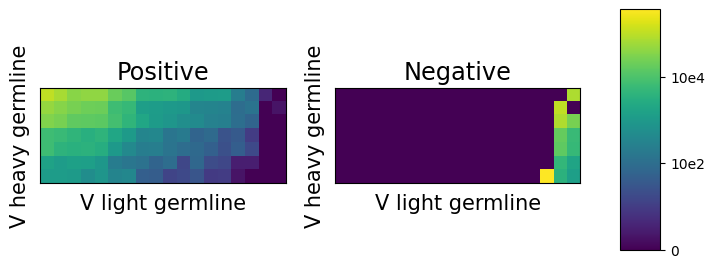

In [33]:
vmin = 0
vmax = max(np.max(coocc_matrix_train_zero), np.max(coocc_matrix_train))

fig, axs = plt.subplots(1, 2)
axs = axs.flatten()

fig.set_size_inches(8, 12)

ret1 = axs[0].imshow(np.log10(coocc_matrix_train + 1), vmin=0, vmax=np.log10(vmax))
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('Positive', fontsize='xx-large')

axs[0].set_ylabel('V heavy germline', fontsize=15)
axs[0].set_xlabel('V light germline', fontsize=15)

axs[1].imshow(np.log10(coocc_matrix_train_zero + 1), vmin=0, vmax=np.log10(vmax))
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Negative', fontsize='xx-large')

axs[1].set_ylabel('V heavy germline', fontsize=15)
axs[1].set_xlabel('V light germline', fontsize=15)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.4, 0.05, 0.2])
fig.colorbar(ret1, cbar_ax, axs)

cbar_ax.set_yticks([0, 2, 4])
cbar_ax.set_yticklabels(['0', '10e2', '10e4'])

fig.savefig('pictures/co-occ-matrix-train-germ-only-v.png', bbox_inches='tight')

### Probability test

In [6]:
naive_pairs = pd.read_csv('{}/sequences/train.csv'.format(DATASET_DIRECTORY), index_col=0)
random_pairs = pd.read_csv('{}/classificator/random/train_random/train_random.csv'.format(DATASET_DIRECTORY), 
                           index_col=0)
sampled_pairs = random_pairs.sample(10000, replace=False)

In [7]:
heavy_germlines = naive_pairs[['heavy_id', 'heavy_germline']]
light_germlines = naive_pairs[['light_id', 'light_germline']]

In [8]:
random_heavy = sampled_pairs[['pair_id', 'heavy_id', 'heavy']].merge(heavy_germlines).drop_duplicates()
print(len(random_heavy))

10001


In [9]:
random_light = sampled_pairs[['pair_id', 'light_id', 'light']].merge(light_germlines).drop_duplicates()
print(len(random_light))

11296


In [10]:
# ci sono più di 10000 sequenze perchè forse ci sono delle sequenze light con associate due o più germlines
random_with_germlines = pd.merge(random_heavy, random_light, on='pair_id')
print(len(random_light))

11296


In [11]:
index_to_delete = []
for _, x in random_with_germlines.groupby('pair_id').filter(lambda x: len(x) > 1).groupby('pair_id'):
    index_to_delete += list(x.index[1:])

In [12]:
random_with_germlines_cleaned = random_with_germlines.loc[
    list(set(random_with_germlines.index).difference(set(index_to_delete)))
    ]

In [13]:
random_with_germlines_cleaned

,pair_id,heavy_id,heavy,heavy_germline,light_id,light,light_germline
0,404989,1050961,QLQLQESGPGLVKPSETLSLTCTVSGGSISSSSYYWGWIRQPPGKG...,HV4-HD6-HJ4,55,EIVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPR...,KV3-KJ5
1,421437,540846,EVQLVESGGGLVQPGGSLRLSCAASGFTFSSYSMNWVRQAPGKGLE...,HV3-HD6-HJ6,636,DIQMTQSPSTLSASVGDRVTITCRASQSISSWLAWYQQKPGKAPKL...,KV1-KJ2
2,315571,855982,QVQLQESGPGLVKPSETLSLTCTVSGGSISSYYWSWIRQPPGKGLE...,HV4-HD3-HJ5,145149,QSALTQPPSASGSPGQSVTISCTGTSSDIGGYNYVSWYQHLPGKAP...,LV2-LJ2
3,95170,927676,QVQLVESGGGVVQPGRSLRLSCAASGFTFSSYGMHWVRQAPGKGLE...,HV3-HD2-HJ6,818,DIVMTQSPLSLPVTPGEPASISCRSSQSLLHSNGYNYLDWYLQKPG...,KV2-KJ3
4,310912,764585,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSQYMHWVRQAPGQGLE...,HV1-HD4-HJ4,80467,QSVLTQPPSVSAAPGQKVTISCSGSSSNIGNNYVSWYQQLPGTAPK...,LV1-LJ3
...,...,...,...,...,...,...,...
11291,278207,908732,QLQLQESGPGLVKPSETLSLTCTVSGGSISSSSYYWGWIRQPPGKG...,HV4-HD6-HJ4,170902,DIQMTQSPSSLSASVGDRVTITCRASQSISSYLNWYQQKPGKAPKL...,KV1-KJ3
11292,227054,1385974,EVQLVESGGGLVQPGGSLRLSCAGSGFRLSGHWMGWVRQAPGKGLE...,HV3-HD3-HJ4,664687,EIVLTQSPATLSLSPGERASLSCRASQSVSSSLAWYQQKPGQPPRL...,KV3-KJ4
11293,570286,251717,EVQLVESGGGLVQPGGSLKLSCAASGFTFSGSAMHWVRQASGKGLE...,HV3-HD3-HJ4,618594,SSELTQDPVVSVALGQTVRITCQGDSLRKYYATWYQQKPGQAPALV...,LV3-LJ2
11294,340522,886156,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYGISWVRQAPGQGLE...,HV1-HD3-HJ6,278,QSVLTQPPSASGTPGQRVTISCSGSSSNIGSNTVNWYQQLPGTAPK...,LV1-LJ2


In [14]:
germline_file_all = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 
                                               'classificator/germline_all/train/train_germ.csv'), index_col=0)

In [15]:
x = random_with_germlines_cleaned.merge(germline_file_all)
len(x[x['counter'] == 0])/len(x) * 100

0.27

In [ ]:
heavy_germlines = germline_file_all.groupby('heavy_germline')['counter'].sum().sort_values(ascending=False)
light_germlines = germline_file_all.groupby('light_germline')['counter'].sum().sort_values(ascending=False)

coocc_matrix = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        y = 

        x = zero_pairs[(zero_pairs['heavy_germline'] == h) &
                       (zero_pairs['light_germline'] == l)]['count']
        if len(x) != 0:
            coocc_matrix_train_zero[r][c] = x.iloc[0]

In [86]:
x

,pair_id,heavy_id,heavy,heavy_germline,light_id,light,light_germline,pairing_index,counter
0,401322,1370230,EMQLVESGGGLVKPGGSLRLSCEASGVTFSTYSMNWVRQAPGKGLE...,HV3-HD6-HJ3,12,DIQMTQSPSSLSASVGDRVTITCQASQDISNYLNWYQQKPGKAPKL...,KV1-KJ4,3966,547
1,164861,1027589,QVQLQESGPGLVKPSETLSLTCTVSGGSISSYYWSWIRQPPGKGLE...,HV4-HD3-HJ4,64851,EIVMTQSPATLSVSPGERATLSCRASQSVSSNLAWYQQKPGQAPRL...,KV3-KJ2,5025,1821
2,105216,161438,QVQLQESGPGLVKPSGTLSLTCVVSGGSINSSNWWSWVRQPPGKGL...,HV4-HD3-HJ4,5073,EIVLTQSPATLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRL...,KV3-KJ2,5025,1821
3,413064,1083648,EVQLVQSGAEVKKPGESLKISCKGSGYSFSSHWIAWVRQMPGGRLE...,HV5-HD3-HJ6,378676,DIQMTQSPSTLSASVGDRVTVTCRASQSVNTWLAWYQQKPGKDPNL...,KV1-KJ2,6414,134
4,179064,573258,EVQLVQSGAEVKKPGESLRISCKGSGYSFTSYWISWVRQMPGKGLE...,HV5-HD3-HJ6,109,DIQMTQSPSTLSASVGDRVTITCRASQSISSWLAWYQQKPGKAPKL...,KV1-KJ2,6414,134
...,...,...,...,...,...,...,...,...,...
995,413630,754027,QVQLQESGPRLVKPSQTLSLTCSVSGAFIKSGGYYWSWIRQHPGKG...,HV4-HD2-HJ5,359783,EIVMTQSPATLSVSPGERATLSCRASQSVSSNLAWYQQKPGQAPRL...,KV3-KJ2,4832,407
996,614446,1460671,QITLKESGPTLVKPTQTLTLTCTFSGFSLSTSGVGVGWIRQPPGKA...,HV2-HD6-HJ5,212668,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGSGYDVHWYQQLPGTAP...,LV1-LJ3,2455,49
997,619737,116223,EVQLVESGGGLVKPGGSLRLSCAASGFTFNDVWMSWVRQAPGKGLE...,HV3-HD4-HJ4,369232,DIQMTQSPSSLSASVGDRITISCRASQAISSYLNWYQQKPRKAPKL...,KV1-KJ5,3460,364
998,73959,1053562,EVQLVESGGGLVKPGGSLRLSCAASGFTFSSYSMNWVRQAPGKGLE...,HV3-HD3-HJ2,250018,QSVLTQPPSASGTPGQRVTISCSGSSSNIGSNYVYWYQQLPGTAPK...,LV1-LJ2,3124,96


0.3

In [3]:
germline_file_all = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 
                                               'classificator/germline_all/train/train_germ.csv'), index_col=0)

In [27]:
heavy_germline_counter = germline_file_all.groupby('heavy_germline')['counter'].sum().sort_values(ascending=False)
light_germline_counter = germline_file_all.groupby('light_germline')['counter'].sum().sort_values(ascending=False)

In [33]:
heavy_germline_probability = heavy_germline_counter.apply(lambda x: x / sum(heavy_germline_counter))
light_germline_probability = light_germline_counter.apply(lambda x: x / sum(light_germline_counter))

In [34]:
light_germline_probability

light_germline
KV1-KJ1    0.093841
LV3-LJ2    0.074116
KV1-KJ2    0.071320
KV1-KJ4    0.067345
KV3-KJ1    0.059668
             ...   
HV3-HJ6    0.000001
LV1-LJ6    0.000001
KV5-KJ3    0.000001
HV4-HJ6    0.000001
LV9-LJ7    0.000001
Name: counter, Length: 68, dtype: float64

In [12]:
for hg, x in germline_file_all.groupby('heavy_germline')['counter']:
    print(hg, x)

HV1-HD1-HJ1 0        19
1        10
2         5
3        14
4         1
         ..
17003     0
17106     0
17398     0
17419     0
17530     0
Name: counter, Length: 68, dtype: int64
HV1-HD1-HJ2 31       17
32       12
33        3
34       13
35        2
         ..
17096     0
17174     0
17238     0
17269     0
17672     0
Name: counter, Length: 68, dtype: int64
HV1-HD1-HJ3 60       214
61       148
62        54
63       115
64        35
        ... 
15564      0
15860      0
15957      0
17381      0
17638      0
Name: counter, Length: 68, dtype: int64
HV1-HD1-HJ4 106      674
107      482
108      212
109      399
110      165
        ... 
13173      0
15003      0
16193      0
16347      0
16995      0
Name: counter, Length: 68, dtype: int64
HV1-HD1-HJ6 163      233
164      184
165       78
166      179
167       71
        ... 
14957      0
14991      0
15599      0
15864      0
15991      0
Name: counter, Length: 68, dtype: int64
HV1-HD2-HJ1 211      53
212      24
213      12

In [42]:
x[x['counter'] == 0]

,heavy_germline,light_germline,pairing_index,counter
211,HV6-HD7-HJ3,KV3-KJ5,12595,0
332,HV1-HD1-HJ1,LV5-LJ3,17530,0
443,HV3-HD6-HJ6,KV5-KJ1,8810,0
590,HV6-HD5-HJ6,KV1-KJ3,12306,0


In [24]:
WHICH = 'train'

random_pairs = pd.read_csv('{}/classificator/germline_v/{}_only_v/{}-germline_pairing-alpha_1000_only_v.csv'.format(DATASET_DIRECTORY, 
                                                                                                        WHICH, WHICH), index_col=0)
report_pairing(random_pairs)

random_pairs_total = pd.read_csv('{}/classificator/germline_v/{}_only_v/{}_only_v.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
print(len(random_pairs_total), 
      len(random_pairs_total[random_pairs_total['class'] == 0]),
      len(random_pairs_total[random_pairs_total['class'] == 1]))

Number of paired sequences:          716325
Number of unique heavy:              259312
Number of unique light:                 150
Number of unique pairs:              511619 (71.42%)
1432650 716325 716325


In [25]:
WHICH = 'val'

random_pairs = pd.read_csv('{}/classificator/germline_v/{}_only_v/{}-germline_pairing-alpha_1000_only_v.csv'.format(DATASET_DIRECTORY, 
                                                                                                        WHICH, WHICH), index_col=0)
report_pairing(random_pairs)

random_pairs_total = pd.read_csv('{}/classificator/germline_v/{}_only_v/{}_only_v.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
print(len(random_pairs_total), 
      len(random_pairs_total[random_pairs_total['class'] == 0]),
      len(random_pairs_total[random_pairs_total['class'] == 1]))

Number of paired sequences:          271233
Number of unique heavy:               68424
Number of unique light:                  73
Number of unique pairs:              154522 (56.97%)
542466 271233 271233


In [26]:
WHICH = 'test'

random_pairs = pd.read_csv('{}/classificator/germline_v/{}_only_v/{}-germline_pairing-alpha_1000_only_v.csv'.format(DATASET_DIRECTORY, 
                                                                                                        WHICH, WHICH), index_col=0)
report_pairing(random_pairs)

random_pairs_total = pd.read_csv('{}/classificator/germline_v/{}_only_v/{}_only_v.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
print(len(random_pairs_total), 
      len(random_pairs_total[random_pairs_total['class'] == 0]),
      len(random_pairs_total[random_pairs_total['class'] == 1]))

Number of paired sequences:          369597
Number of unique heavy:               78250
Number of unique light:                  71
Number of unique pairs:              208502 (56.41%)
739194 369597 369597


In [27]:
germline_file_all = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'classificator/germline_all/val/val_germ.csv'), index_col=0)
heavy_germlines = germline_file_all.groupby('heavy_germline')['counter'].sum().sort_values(ascending=False)
light_germlines = germline_file_all.groupby('light_germline')['counter'].sum().sort_values(ascending=False)

coocc_matrix_val = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        coocc_matrix_val[r][c] = germline_file_all[(germline_file_all['heavy_germline'] == h) & 
                                                   (germline_file_all['light_germline'] == l)]['counter'].iloc[0]

In [28]:
germline_file_all = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'classificator/germline_all/val/val_germ.csv'), index_col=0)
heavy_germlines = germline_file_all.groupby('heavy_germline')['counter'].sum().sort_values(ascending=False)
light_germlines = germline_file_all.groupby('light_germline')['counter'].sum().sort_values(ascending=False)

coocc_matrix_test = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        coocc_matrix_test[r][c] = germline_file_all[(germline_file_all['heavy_germline'] == h) & 
                                                   (germline_file_all['light_germline'] == l)]['counter'].iloc[0]

In [22]:
coocc_matrix = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        coocc_matrix[r][c] = germline_file_all[(germline_file_all['heavy_germline'] == h) & 
                                               (germline_file_all['light_germline'] == l)]['counter'].iloc[0]

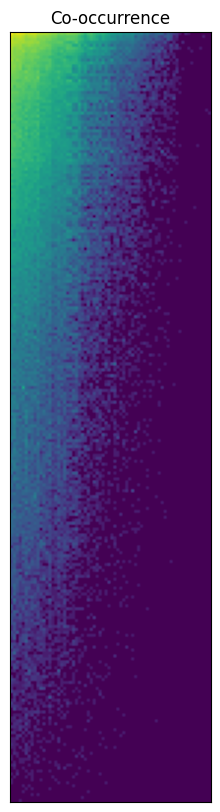

In [23]:
fig, ax = plt.subplots(1)

fig.set_size_inches(3, 10)

show_coocc_matrix(coocc_matrix, heavy_germlines, light_germlines, ax=ax)

In [47]:
train_neg = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 
                                       'classificator/train/train-germline_pairing-alpha_1000.csv'), index_col=0)
germlines_train = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 
                                             'classificator/train/train_germ.csv'), index_col=0)

train_neg = pd.merge(train_neg, germlines_train, how='left')

In [48]:
zero_pairs = defaultdict(list)

for h, data1 in train_neg.groupby('heavy_germline'):
    for l, data2 in data1.groupby('light_germline'):
        zero_pairs['heavy_germline'].append(h)
        zero_pairs['light_germline'].append(l)
        zero_pairs['count'].append(len(data2))

zero_pairs = pd.DataFrame(zero_pairs)

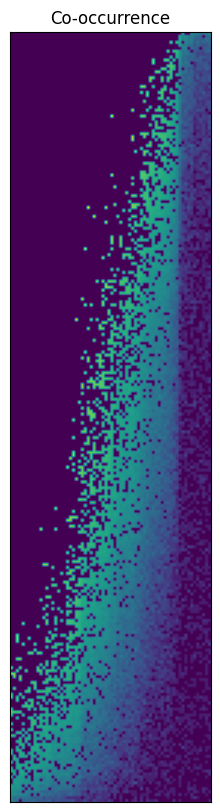

In [49]:
coocc_matrix_zero = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        x = zero_pairs[(zero_pairs['heavy_germline'] == h) &
                       (zero_pairs['light_germline'] == l)]['count']
        if len(x) != 0:
            coocc_matrix_zero[r][c] = x.iloc[0]

fig, ax = plt.subplots(1)

fig.set_size_inches(3, 10)

show_coocc_matrix(coocc_matrix_zero, heavy_germlines, light_germlines, ax)

### Germline pairing - only v

In [53]:
germline_file_all = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'classificator/train_only_v/train_germ_only_v.csv'), index_col=0)
heavy_germlines = germline_file_all.groupby('heavy_germline')['counter'].sum().sort_values(ascending=False)
light_germlines = germline_file_all.groupby('light_germline')['counter'].sum().sort_values(ascending=False)

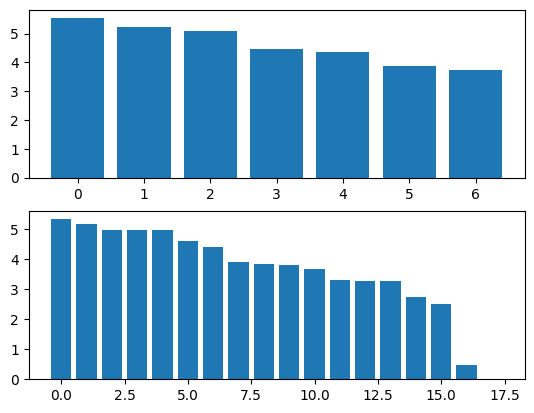

In [54]:
fig, axs = plt.subplots(2, 1)
axs = axs.flatten()

show_germline_counter(heavy_germlines, light_germlines, ax_heavy=axs[0], ax_light=axs[1])

In [55]:
coocc_matrix = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        coocc_matrix[r][c] = germline_file_all[(germline_file_all['heavy_germline'] == h) & 
                                               (germline_file_all['light_germline'] == l)]['counter'].iloc[0]

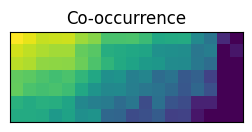

In [56]:
fig, ax = plt.subplots(1)

fig.set_size_inches(3, 10)

show_coocc_matrix(coocc_matrix, heavy_germlines, light_germlines, ax=ax)

In [58]:
train_neg = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 
                                       'classificator/train_only_v/train-germline_pairing-alpha_1000_only_v.csv'), index_col=0)
germlines_train = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 
                                             'classificator/train_only_v/train_germ_only_v.csv'), index_col=0)

train_neg = pd.merge(train_neg, germlines_train, how='left')

In [59]:
zero_pairs = defaultdict(list)

for h, data1 in train_neg.groupby('heavy_germline'):
    for l, data2 in data1.groupby('light_germline'):
        zero_pairs['heavy_germline'].append(h)
        zero_pairs['light_germline'].append(l)
        zero_pairs['count'].append(len(data2))

zero_pairs = pd.DataFrame(zero_pairs)

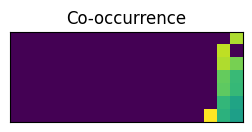

In [60]:
coocc_matrix_zero = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        x = zero_pairs[(zero_pairs['heavy_germline'] == h) &
                       (zero_pairs['light_germline'] == l)]['count']
        if len(x) != 0:
            coocc_matrix_zero[r][c] = x.iloc[0]

fig, ax = plt.subplots(1)

fig.set_size_inches(3, 10)

show_coocc_matrix(coocc_matrix_zero, heavy_germlines, light_germlines, ax)

### Similarity

In [60]:
paired_df = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'classificator/train/train_seq.csv'), index_col=0)
random_df = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'classificator/train_random/train_random.csv'), index_col=0)
germline_all_df = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'classificator/train/train-germline_pairing-alpha_1000.csv'),
                           index_col=0)
germline_v_df = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'classificator/train_only_v/train-germline_pairing-alpha_1000_only_v.csv'),
                         index_col=0)

In [61]:
heavy_ids = set(paired_df['heavy_id'])
heavy_ids = heavy_ids.intersection(set(random_df['heavy_id']))
heavy_ids = heavy_ids.intersection(set(germline_all_df['heavy_id']))
heavy_ids = heavy_ids.intersection(set(germline_v_df['heavy_id']))

In [62]:
sampled_heavy = random.sample(list(heavy_ids), 1000)

In [63]:
paired_seq = []
for s in sampled_heavy:
    x = paired_df[paired_df['heavy_id'] == s][['heavy', 'light']].iloc[0, :]
    paired_seq.append('{}{}'.format(x['heavy'], x['light']))

In [64]:
random_seq = []
for s in sampled_heavy:
    x = random_df[random_df['heavy_id'] == s][['heavy', 'light']].iloc[0, :]
    random_seq.append('{}{}'.format(x['heavy'], x['light']))

In [65]:
germline_v_seq = []
for s in sampled_heavy:
    x = germline_v_df[germline_v_df['heavy_id'] == s][['heavy', 'light']].iloc[0, :]
    germline_v_seq.append('{}{}'.format(x['heavy'], x['light']))

In [66]:
germline_all_seq = []
for s in sampled_heavy:
    x = germline_all_df[germline_all_df['heavy_id'] == s][['heavy', 'light']].iloc[0, :]
    germline_all_seq.append('{}{}'.format(x['heavy'], x['light']))

In [74]:
def intra_sim(l):
    values = []
    for x, y in combinations(l, 2):
        values.append(Levenshtein.ratio(x, y))
    print('|{:^10}|{:^10}|{:^10}|{:^10}|'.format('mean', 'std', 'min', 'max'))
    print('|{:^10.4f}|{:^10.4f}|{:^10.4f}|{:^10.4f}|'.format(
        np.mean(values), np.std(values), np.min(values), np.max(values)))

print('Intra-distance')
print()
print('paired')
intra_sim(paired_seq)
print()
print('random')
intra_sim(random_seq)
print()
print('germline_v')
intra_sim(germline_v_seq)
print()
print('germline_all')
intra_sim(germline_all_seq)

Intra-distance

paired
|   mean   |   std    |   min    |   max    |
|  0.6242  |  0.0843  |  0.4163  |  0.9784  |

random
|   mean   |   std    |   min    |   max    |
|  0.6226  |  0.0834  |  0.4301  |  0.9698  |

germline_v
|   mean   |   std    |   min    |   max    |
|  0.6697  |  0.1249  |  0.3958  |  0.9899  |

germline_all
|   mean   |   std    |   min    |   max    |
|  0.5876  |  0.0882  |  0.3974  |  0.9873  |


In [75]:
def inter_sim(l1, l2):
    values = []
    for x, y in product(l1, l2):
        values.append(Levenshtein.ratio(x, y))
    print('|{:^10}|{:^10}|{:^10}|{:^10}|'.format('mean', 'std', 'min', 'max'))
    print('|{:^10.4f}|{:^10.4f}|{:^10.4f}|{:^10.4f}|'.format(
        np.mean(values), np.std(values), np.min(values), np.max(values)))

print('Inter-distance')
print()
print('random')
inter_sim(paired_seq, random_seq)
print()
print('germline_v')
inter_sim(paired_seq, germline_v_seq)
print()
print('germline_all')
inter_sim(paired_seq, germline_all_seq)

Inter-distance

random
|   mean   |   std    |   min    |   max    |
|  0.6235  |  0.0840  |  0.4077  |  0.9957  |

germline_v
|   mean   |   std    |   min    |   max    |
|  0.5279  |  0.0608  |  0.3859  |  0.8283  |

germline_all
|   mean   |   std    |   min    |   max    |
|  0.5875  |  0.0698  |  0.4142  |  0.9871  |
